## **Example. Stratified sampling in pre-election polling**

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt
import arviz
import seaborn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

A survey of 1447 adults.

In [4]:
participants = 1447

This is the Table 8.2

In [5]:
data = pd.read_csv('data/cbs_survey.txt', sep=' ', skiprows=2, skipinitialspace=True, index_col=False)
data

,region,density,bush,dukakis,other,proportion
0,Northeast,I,0.298,0.617,0.085,0.032
1,Northeast,II,0.500,0.478,0.022,0.032
2,Northeast,III,0.467,0.413,0.120,0.115
3,Northeast,IV,0.464,0.522,0.014,0.048
4,Midwest,I,0.404,0.489,0.106,0.032
5,Midwest,II,0.447,0.447,0.106,0.065
6,Midwest,III,0.509,0.388,0.103,0.080
7,Midwest,IV,0.552,0.338,0.110,0.100
8,South,I,0.571,0.286,0.143,0.015
9,South,II,0.469,0.406,0.125,0.066


We need the number of people of each region and each candidate.

In [6]:
data_obs = data[['bush', 'dukakis', 'other']].to_numpy()
print(data_obs)

[[0.298 0.617 0.085]
 [0.5   0.478 0.022]
 [0.467 0.413 0.12 ]
 [0.464 0.522 0.014]
 [0.404 0.489 0.106]
 [0.447 0.447 0.106]
 [0.509 0.388 0.103]
 [0.552 0.338 0.11 ]
 [0.571 0.286 0.143]
 [0.469 0.406 0.125]
 [0.515 0.404 0.081]
 [0.555 0.352 0.093]
 [0.5   0.471 0.029]
 [0.532 0.351 0.117]
 [0.54  0.371 0.089]
 [0.554 0.361 0.084]]


In [7]:
proportion = data['proportion'].to_numpy() * participants
print(proportion)

[ 46.304  46.304 166.405  69.456  46.304  94.055 115.76  144.7    21.705
  95.502  98.396 182.322  33.281  76.691 124.442  82.479]


In [8]:
print(data_obs.shape)
print(proportion.shape)

(16, 3)
(16,)


In [9]:
valores = data_obs[:, :] * proportion.reshape(16, -1)
valores = np.round(valores)
np.sum(valores)   # Check if the sum is equal to 1447

1447.0

### **Nonhierarchical model**

In [10]:
with pm.Model() as model_non_hiera:
    
    thetas = pm.Dirichlet('thetas', a=np.ones_like(data_obs), shape=(16, 3))
    post = pm.Multinomial('post', n=np.sum(valores, axis=1), p=thetas, observed=valores)

In [11]:
model_non_hiera.check_test_point()

thetas_stickbreaking__    -41.64
post                     -322.85
Name: Log-probability of test_point, dtype: float64

In [12]:
pm.model_to_graphviz(model_non_hiera)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

In [13]:
with model_non_hiera:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:14<00:00, 1119.48draws/s]


In [14]:
pm.traceplot(trace_1, var_names=['thetas__15_2']);

<Figure size 864x0 with 0 Axes>

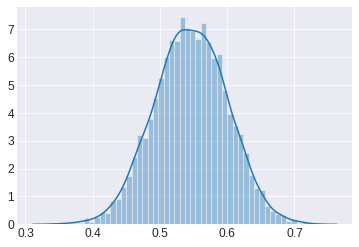

In [15]:
seaborn.distplot(trace_1['thetas'][:, 15, 0])

In [16]:
pm.summary(trace_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thetas__0_0,0.299653,0.063840,0.000534,0.176089,0.423617,19226.807333,0.999785
thetas__0_1,0.600337,0.069006,0.000571,0.460822,0.729916,18468.245681,0.999809
thetas__0_2,0.100010,0.042210,0.000300,0.024209,0.181230,15983.247000,0.999842
thetas__1_0,0.490342,0.070030,0.000527,0.352220,0.622480,15033.358733,0.999812
thetas__1_1,0.468789,0.070418,0.000516,0.329812,0.603250,14397.420075,0.999846
thetas__1_2,0.040869,0.027871,0.000216,0.000746,0.095530,13813.564556,0.999929
thetas__2_0,0.464064,0.037702,0.000243,0.392602,0.538467,19458.166318,0.999827
thetas__2_1,0.412692,0.036871,0.000283,0.340354,0.485125,18771.180462,0.999881
thetas__2_2,0.123243,0.025265,0.000194,0.074236,0.172532,19247.971606,1.000048
thetas__3_0,0.458331,0.058274,0.000404,0.350884,0.573547,21956.980693,0.999798


Now, the goal is to reproduce the figure 8.1 (a).

In [17]:
with model_non_hiera:
    ppc_non_hiera = pm.sample_posterior_predictive(trace_1, samples=1000, vars=[thetas, post])

100%|██████████| 1000/1000 [00:01<00:00, 889.86it/s]


In [18]:
ppc_non_hiera['thetas'].shape

(1000, 16, 3)

Just check if the column **proportion** (look at the data frame) is equal to what we got.

In [19]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [20]:
diff = []

for i in range(16):
    result = ppc_non_hiera['thetas'][:, i, 0] - ppc_non_hiera['thetas'][:, i, 1]
    diff.append(list(result))

In [21]:
diff = np.asarray(diff)
diff

array([[-0.36602273, -0.19682315, -0.36796852, ..., -0.48749388,
        -0.32218869, -0.04764414],
       [-0.02860091,  0.13603276, -0.15743739, ..., -0.17841541,
         0.26005232,  0.15633098],
       [ 0.09419482,  0.08172248,  0.02700719, ...,  0.07112208,
         0.06369524,  0.01833077],
       ...,
       [ 0.2096655 ,  0.12545752,  0.34367845, ...,  0.25501784,
         0.31038741,  0.20693177],
       [ 0.24176366,  0.22392918,  0.20225605, ...,  0.16170903,
         0.09215016,  0.12158467],
       [ 0.26952366,  0.11230593,  0.32890665, ...,  0.31401458,
         0.10214156,  0.15254369]])

In [22]:
res = np.sum(diff.T * proportion / np.sum(proportion), axis=1)

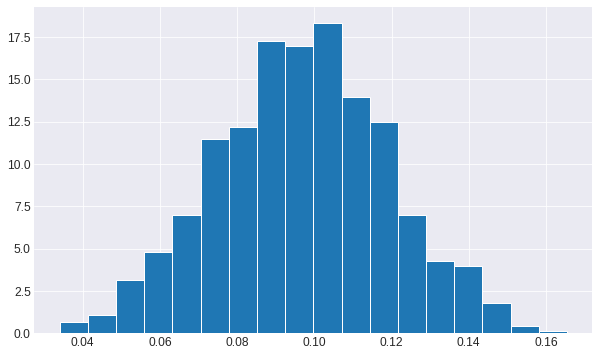

In [23]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res, bins=18, edgecolor='w', density=True)

### **Hierarchichal model**

The authors are using other parameters, so we need to find the number of people for $\alpha_{1j}$ and $\alpha_{2j}$.

In [24]:
alpha_2j = np.round((1 - data['other'].to_numpy()) * data.proportion.to_numpy() * participants)
print(alpha_2j)

[ 42.  45. 146.  68.  41.  84. 104. 129.  19.  84.  90. 165.  32.  68.
 113.  76.]


In [56]:
alpha_1j = valores[:, 1] / (valores[:, 0] + valores[:, 1])
print(alpha_1j)

[0.6744186  0.48888889 0.46938776 0.52941176 0.54761905 0.5
 0.43269231 0.37984496 0.33333333 0.46428571 0.43956044 0.38787879
 0.48484848 0.39705882 0.40707965 0.39473684]


In [57]:
new_values = np.round(np.stack([alpha_1j * data.proportion.to_numpy() * participants, alpha_2j], axis=1))
print(new_values)

[[ 31.  42.]
 [ 23.  45.]
 [ 78. 146.]
 [ 37.  68.]
 [ 25.  41.]
 [ 47.  84.]
 [ 50. 104.]
 [ 55. 129.]
 [  7.  19.]
 [ 44.  84.]
 [ 43.  90.]
 [ 71. 165.]
 [ 16.  32.]
 [ 30.  68.]
 [ 51. 113.]
 [ 33.  76.]]


In [58]:
with pm.Model() as model_hier:
    
# #     rho = pm.Uniform('rho', lower=0, upper=1)
#     rho = pm.Normal('rho', mu=-0.5, sd=.2)
# #     mu = pm.Uniform('mu', lower=0, upper=50, shape=(2,))
#     mu = pm.HalfNormal('mu', sd=4, shape=(2,))
# #     mu2 = pm.HalfNormal('mu2', sd=1.4)
# #     tau = pm.Uniform('tau', lower=-2, upper=3, shape=(2,))
#     tau = pm.Beta('tau', alpha=2, beta=2, shape=(2,))
    
#     covariance = tt.stack([[tau[0]**2, rho * tau[0] * tau[1]], [rho * tau[0] * tau[1], tau[1]**2]], axis=1)
# #     print(covariance)
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(5))

    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    mu = pm.Normal('mu', 0., 10., shape=2, testval=new_values.mean(axis=0))
    beta = pm.MvNormal('beta', mu=mu, chol=L, shape=2)
    
#     beta = pm.MvNormal('beta', mu=mu, cov=covariance, shape=2)
    
    alpha1 = pm.invlogit(beta[0])
    alpha2 = pm.invlogit(beta[1])
    
    alphas = pm.Dirichlet('alphas', a=tt.stack([alpha1, alpha2], axis=1), shape=(16, 2))
#     alphas = pm.Dirichlet('alphas', a=np.array([alpha1, alpha2]), shape=(16, 2))

    post = pm.Multinomial('post', n=np.sum(new_values, axis=1), p=alphas, observed=new_values)

In [59]:
model_hier.check_test_point()

packed_L_cholesky-cov-packed__     -3.91
mu                                -47.78
beta                               -1.84
alphas_stickbreaking__            -22.18
post                             -159.77
Name: Log-probability of test_point, dtype: float64

In [60]:
pm.model_to_graphviz(model_hier)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

In [85]:
with model_hier:
    trace_2 = pm.sample(draws=2_000, tune=1_000, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas, beta, mu, packed_L]
Sampling 4 chains: 100%|██████████| 12000/12000 [23:40<00:00,  2.55draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


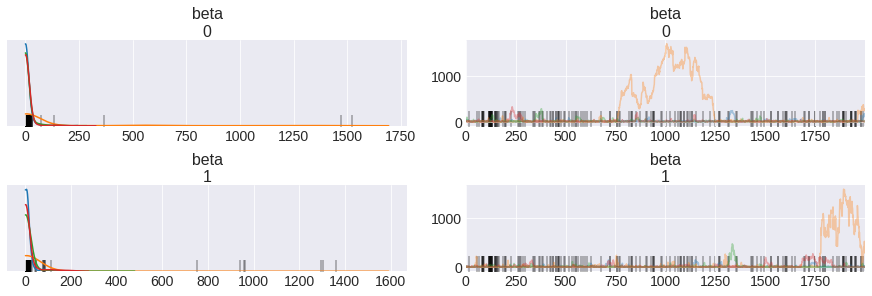

In [86]:
pm.traceplot(trace_2, var_names=['beta']);

In [87]:
pm.summary(trace_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,6.093069,8.234688e+00,0.180893,-10.544320,23.177832,1487.397063,1.003119
mu__1,6.828961,8.101430e+00,0.207703,-10.357080,22.868710,1295.971757,1.002388
beta__0,71.476829,2.364595e+02,22.766323,-0.432098,518.181069,20.715361,1.118284
beta__1,45.594681,1.622495e+02,14.815154,0.717871,127.227294,29.192842,1.046725
packed_L__0,87.552578,4.057062e+02,29.018480,0.067557,420.374156,37.670767,1.061497
packed_L__1,15.383483,9.962871e+01,9.395267,-85.943822,78.652195,58.090749,1.028396
packed_L__2,48.618601,2.808802e+02,19.692748,0.048352,150.110619,62.179535,1.021208
Sigma__0_0,172262.998738,1.954825e+06,75746.255571,0.004564,176714.430813,200.089723,1.014189
Sigma__0_1,925.703579,1.274978e+04,632.969995,-1382.733453,2487.531151,275.110813,1.009295
Sigma__1_0,925.703579,1.274978e+04,632.969995,-1382.733453,2487.531151,275.110813,1.009295


In [88]:
matrix_s = trace_2['Sigma'].mean(axis=0)

In [89]:
matrix_s

array([[172262.99873826,    925.7035785 ],
       [   925.7035785 ,  91419.98320238]])

In [90]:
tau1, tau2 = np.sqrt(matrix_s[0, 0]), np.sqrt(matrix_s[1, 1])
print(tau1, tau2)

415.0457790873895 302.35737662968336


In [91]:
rho = matrix_s[1, 0] / (tau1 * tau2)

In [92]:
rho

0.007376585362288601

In [93]:
with model_hier:
    ppc_hier = pm.sample_posterior_predictive(trace_2, samples=1000, vars=[alphas])

100%|██████████| 1000/1000 [00:00<00:00, 23062.73it/s]


In [94]:
ppc_hier['alphas'].shape

(1000, 16, 2)

In [95]:
valores[:, 0] / (valores[:, 0] + valores[:, 1])

array([0.3255814 , 0.51111111, 0.53061224, 0.47058824, 0.45238095,
       0.5       , 0.56730769, 0.62015504, 0.66666667, 0.53571429,
       0.56043956, 0.61212121, 0.51515152, 0.60294118, 0.59292035,
       0.60526316])

In [96]:
ppc_hier['alphas'][250, :, :]

array([[0.34716292, 0.65283708],
       [0.35770391, 0.64229609],
       [0.28406868, 0.71593132],
       [0.32453006, 0.67546994],
       [0.4686527 , 0.5313473 ],
       [0.33529416, 0.66470584],
       [0.35546567, 0.64453433],
       [0.28125523, 0.71874477],
       [0.31280583, 0.68719417],
       [0.32138581, 0.67861419],
       [0.33186565, 0.66813435],
       [0.29384942, 0.70615058],
       [0.26703781, 0.73296219],
       [0.34783915, 0.65216085],
       [0.29775929, 0.70224071],
       [0.27425   , 0.72575   ]])

In [97]:
th1 = []

for i in range(16):
#     result1 =  2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] - ppc_hier['alphas'][:, i, 1] 
    result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th1.append(list(result1))

In [98]:
# print(th1

In [99]:
th1 = np.asarray(th1)
th1.shape

(16, 1000)

In [100]:
res2 = np.sum(th1.T * proportion / np.sum(proportion), axis=1)
res2[:15]

array([0.23662175, 0.23282416, 0.22871552, 0.25399912, 0.23206242,
       0.23172383, 0.28342552, 0.21808228, 0.25160088, 0.26640258,
       0.21603326, 0.22289922, 0.22426174, 0.23504322, 0.23136687])

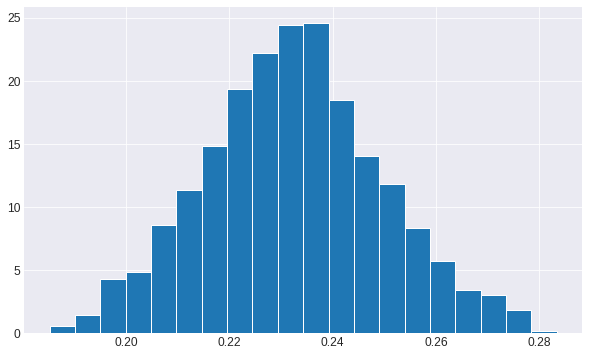

In [101]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2 , bins=20, edgecolor='w', density=True)

In [ ]:
%load_ext watermark

In [ ]:
%watermark -iv -v -p theano,scipy,matplotlib -m

### Intento con pystan